In [20]:
import sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

import gw150814_simulator as gs
from src.utils.comb import Comb3, Comb3_Torch
from gw150814_simulator import GW150814_Additive
# import module

import torch
import numpy as np
import scipy
import scipy.stats
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
pf.housestyle_rcparams()

import matplotlib.pyplot as plt

import os, sys

from simulators.additive import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

mycolors = ['#77aca2', '#ff004f', '#f98e08']
# device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')


In [21]:
class Network_Comb(torch.nn.Module):
    def __init__(self, n_bins):
        super().__init__()
        self.online_norm = OnlineStandardizingLayer((n_bins,), use_average_std=True)
        self.net = ResidualNet(1, 1, 128) # 1 input channel, 1 output channel, 128 hidden features
        self.logvariance = torch.nn.Parameter(torch.ones(n_bins)*5)

    def epsilon(self, x):
        x = self.online_norm(x)
        x = self.net(x.unsqueeze(1)).squeeze(1)
        return x
    
    def epsilon(self, x):
        x = self.online_norm(x)
        x = self.net(x.unsqueeze(1)).squeeze(1)
        return x
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    def forward(self, x):

        data = x['xi']
        # epsilon_real = x['epsilon']
        epsilon_sim =  (2 * self.bounds() * torch.rand(x['xi'].shape, device= x['xi'].device, dtype= x['xi'].dtype) - self.bounds()) * x['ni']

        epsilon = self.epsilon(data)
        mask = ( x['ni'] != 0 )  
        squared_error = (epsilon - epsilon_sim)**2                                                                    # [B, N_bins]
        l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
        return (l * mask.float()).sum() * 0.5

class Network_SNR(torch.nn.Module):
        def __init__(self):
            super().__init__()
            
            self.online_norm = OnlineStandardizingLayer((Nbins,), use_average_std=True) 
            self.net = ResidualNet(1, 1, 128)
            self.logvariance = torch.nn.Parameter(torch.ones(Nbins)*5)
                    
        def epsilon(self, x):
            x = self.online_norm(x)
            x = self.net(x.unsqueeze(1)).squeeze(1)
            return x
        
        def snr(self, x):
            return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
        
        def bounds(self):
            return self.logvariance.detach().exp().sqrt().mean(-1) * 5
            
        def forward(self, x):
            
            # Adaptive data generation
            ni = x['ni']
            epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, device= x['x'].device, dtype= x['x'].dtype) - self.bounds()) * ni
            data =  x['x0'] + epsilon_sim * ni

            epsilon = self.epsilon(data)
            mask = ( x['ni'] != 0 )  
            squared_error = (epsilon - epsilon_sim)**2                                                                    # [B, N_bins]
            l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
            return (l * mask.float()).sum() * 0.5


## Evaluating The Network

First start with a sanity check using some parity plots

In [23]:
network = torch.load('out/long_uc_model', weights_only=False, map_location=torch.device('cpu'))
network_epsilon = torch.load('out/long_uc_network', weights_only=False,  map_location=torch.device('cpu'))
Nbins = 1000
SIGMA = 1

gen_samples = np.load('FD_samples.npz')
gw150814_post = torch.tensor(gen_samples['waveform'])
gw150814_noise = torch.tensor(gen_samples['noise'])
gw150814_samples = {'mu': gw150814_post, 'noise': gw150814_noise}
simulator = GW150814_Additive(
    gw150814_samples=gw150814_samples, 
    bounds=2, 
    dtype=torch.float64,
    fraction = 0.5
) 

Loading data for H1 at GPS time 1126259462.4
Loading PSD for H1 at GPS time 1126259462.4 [can take O(1 min)]
Loading posterior samples from ../../mist-base/GW/GW150814_posterior_samples.npz


In [25]:

######### - 1 - ###########

n = 50
obs = simulator.sample(1)  
# fit = best_fit(obs['xi'][0], simulator)
delta_x = (obs['xi'] - fit).to(dtype=torch.float32)

######### - 2 - ###########

ni = torch.eye(Nbins, dtype=obs['xi'].dtype)

# epsilon_nn_obs = network_epsilon.epsilon(delta_x.cuda()).detach().cpu().numpy().squeeze(0)
epsilon_nn_obs = network_epsilon.epsilon(delta_x.to(dtype=torch.float32,device='mps')).detach().cpu().numpy().squeeze(0)
variance_nn_obs = network_epsilon.logvariance.exp().detach().cpu().numpy()
# snr_nn_obs = network_epsilon.snr(delta_x.cuda()).detach().cpu().numpy().squeeze(0)
snr_nn_obs = network_epsilon.snr(delta_x.to(dtype=torch.float32,device='mps')).detach().cpu().numpy().squeeze(0)

epsilon_obs = get_epsilon(delta_x, ni).squeeze(0)
variance_obs = 1 / get_sigma_epsilon_inv2(ni)
snr_obs = get_snr(delta_x, ni).squeeze(0)

######### - 3 - ###########

fig, ax1 = pf.create_plot(size=(4,3))
ax2 = fig.add_axes((1.3,0,1,1))
ax3 = fig.add_axes((2.6,0,1,1))
axs = [ax1,ax2,ax3]

axs[0].scatter(x=epsilon_obs, y=epsilon_nn_obs, c='C1', s=30, marker='o',linewidths=0.4, alpha=0.7)
axs[1].scatter(x=variance_obs, y=variance_nn_obs, c='C1', s=30, marker='o',linewidths=0.4, alpha=0.7)
axs[2].scatter(x=snr_obs, y=snr_nn_obs, c='C1', s=30, marker='o',linewidths=0.4, alpha=0.7)    

idx = torch.where(obs['ni']==1)[1]
axs[0].scatter(x=epsilon_obs[idx], y=epsilon_nn_obs[idx], c='C0', s=50, marker='x',linewidths=2)
axs[1].scatter(x=variance_obs[idx], y=variance_nn_obs[idx], c='C0', s=50, marker='x',linewidths=2)
axs[2].scatter(x=snr_obs[idx], y=snr_nn_obs[idx], c='C0', s=50, marker='x',linewidths=2)   


axs[0].set_xlabel(r'$\epsilon$ true')
axs[0].set_ylabel(r'$\epsilon$ NN')
axs[1].set_xlabel(r'$\sigma^2$ true')
axs[1].set_ylabel(r'$\sigma^2$ NN')
axs[2].set_xlabel('SNR True')
axs[2].set_ylabel('SNR NN')
pf.fix_plot(axs)
plt.tight_layout();

NameError: name 'fit' is not defined

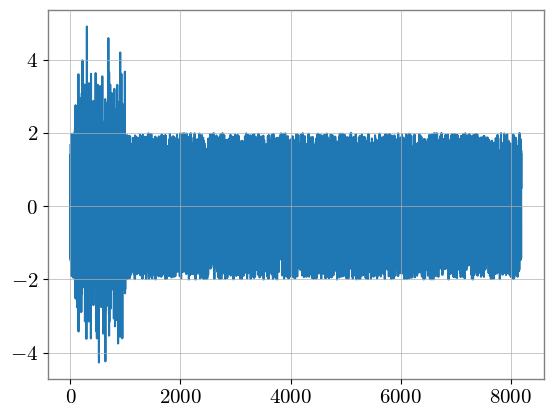

In [35]:
obs = simulator.sample(1)  
obs['x0']
plt.plot(np.squeeze((obs['x0']-obs['epsilon'])))

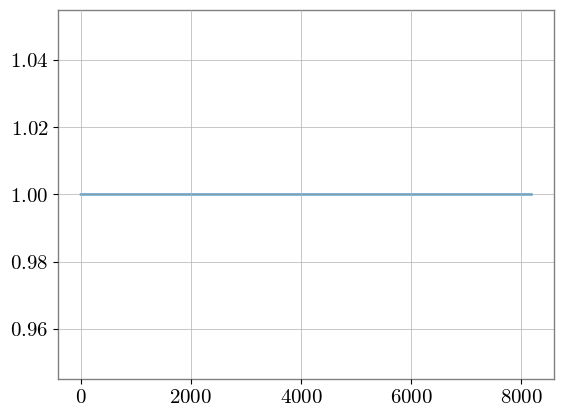

In [40]:
plt.plot(simulator.sample(1)['ni'].squeeze())